## Importando as bibliotecas

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from PIL import ImageFont
import numpy as np
import pandas as pd

import tensorflow as tf
import visualkeras
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OrdinalEncoder

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

import matplotlib.pyplot as plt
plt.rcParams.update({
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.size": 12,
    "font.family": "Lato",
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True
    })

## Carregando os dados

In [2]:
df = pd.read_parquet("../data/moderna10k.parquet")

In [3]:
def total_mixing_ratio(df, nplaneta):
    abudancias = []

    for i in range(60):
        camada = df[f"ATMOSPHERE-LAYER-{i+1}"]
        abundancias_camada = [float(valor) for valor in camada[nplaneta].split(",")[2:]]
        abudancias.append(abundancias_camada)

    abd_soma = np.sum(np.array(abudancias), axis=0)
    abd_normalizada = abd_soma/np.sum(abd_soma)

    return np.array(abd_normalizada)

In [4]:
features_names = [
    "OBJECT-DIAMETER",
    "OBJECT-GRAVITY",
    "OBJECT-STAR-DISTANCE",
    "OBJECT-STAR-TYPE",
    "OBJECT-STAR-TEMPERATURE",
    "OBJECT-STAR-RADIUS",
    "OBJECT-STAR-METALLICITY",
    "ATMOSPHERE-PRESSURE",
]
df_filtrado = df[features_names]

## Tratamento dos dados

In [5]:
dados_dic = df_filtrado.to_dict(orient="records")

In [6]:
# Faz o Ordinal Encoding nos tipos das estrelas
tipos_estrelas = df_filtrado[['OBJECT-STAR-TYPE']]
ordinal_encoder = OrdinalEncoder()
tipos_estrelas_encoded = ordinal_encoder.fit_transform(tipos_estrelas)

In [7]:
for nplaneta in range(len(df)):
  # Adiciona o tipo das estrelas no formato Ordinal Encoding
  dados_dic[nplaneta]['OBJECT-STAR-TYPE-ENCODED'] = int(tipos_estrelas_encoded[nplaneta][0])

  # Converte o valor da pressão atmosférica de string para float
  dados_dic[nplaneta]['ATMOSPHERE-PRESSURE'] = float(dados_dic[nplaneta]['ATMOSPHERE-PRESSURE'])

  # Agrupa todos os features secundários
  features_secundarios = [
      dados_dic[nplaneta]['OBJECT-STAR-TYPE-ENCODED'],
      dados_dic[nplaneta]['OBJECT-STAR-RADIUS'],
      dados_dic[nplaneta]['OBJECT-DIAMETER']/1000,
      dados_dic[nplaneta]['OBJECT-STAR-TEMPERATURE']/1000,
      dados_dic[nplaneta]['ATMOSPHERE-PRESSURE']/1000,
      dados_dic[nplaneta]['OBJECT-STAR-DISTANCE'],
      dados_dic[nplaneta]['OBJECT-STAR-METALLICITY'],
      dados_dic[nplaneta]['OBJECT-GRAVITY'],
  ]

  # Adiciona um array com todos os features secundários
  dados_dic[nplaneta]['SECONDARY-FEATURES'] = np.array(features_secundarios)

  # Adiciona o albedo aos dicionários
  albedo_str = df.iloc[nplaneta]["ALBEDO"]
  albedo = np.array([float(value) for value in albedo_str.split(',')])
  dados_dic[nplaneta]['ALBEDO'] = albedo

  # Agrupa os dados de abundância média
  dados_dic[nplaneta]['TOTAL-ABUNDANCES'] = total_mixing_ratio(df, nplaneta)

## Salva em TFRecord

In [8]:
"""
As funções seguintes podem ser usadas para converter um valor em um tipo
compatível com o formato ft.train.Example.
"""
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):   # if value ist tensor
    value = value.numpy() # BytesList won"t unpack a string from an EagerTensor. (get value of tensor)
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def float_feature_list(value):
  """Returns a list of float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

def save_features(planet_dic):
  # This function was created only to save some space in the saving processing
  # code.
  features = {
    "star_type" : _bytes_feature(planet_dic["OBJECT-STAR-TYPE"].encode()),
    "star_type_encoded" : _int64_feature(planet_dic["OBJECT-STAR-TYPE-ENCODED"]),

    "star_radius" : _float_feature(planet_dic["OBJECT-STAR-RADIUS"]),
    "planet_diameter" : _float_feature(planet_dic["OBJECT-DIAMETER"]),
    "star_temperature" : _float_feature(planet_dic["OBJECT-STAR-TEMPERATURE"]),
    "atmosphere_pressure" : _float_feature(planet_dic["ATMOSPHERE-PRESSURE"]),
    "star_distance" : _float_feature(planet_dic["OBJECT-STAR-DISTANCE"]),
    "star_metalicity" : _float_feature(planet_dic["OBJECT-STAR-METALLICITY"]),
    "planet_gravity" : _float_feature(planet_dic["OBJECT-GRAVITY"]),

    "secondary_features" : float_feature_list(planet_dic["SECONDARY-FEATURES"]),

    "albedo" : float_feature_list(planet_dic["ALBEDO"]),

    "total_abundance" : float_feature_list(planet_dic["TOTAL-ABUNDANCES"])
  }

  return features

In [9]:
file = "../data/dados.tfrecord"

# Write TFrecord file
with tf.io.TFRecordWriter(file) as writer:
  for planet in dados_dic:
    feature = save_features(planet)
    example_message = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example_message.SerializeToString())

## Carrega o TFRecord

In [10]:
def parse_geexhp_data(record):
  # Faz com que o TFRecordDataset receba todos os dados do dataset.
  features = {
    "secondary_features" : tf.io.FixedLenFeature((8,), dtype=tf.float32),
    "albedo" : tf.io.FixedLenFeature((1583,), dtype=tf.float32),
    "total_abundance" : tf.io.FixedLenFeature((15,), dtype=tf.float32)
  }

  # Cria um exemplo para cada dado no dataset recebido
  example = tf.io.parse_single_example(record, features)

  # Guarda o label de cada dado recebido do dataset
  label = example["total_abundance"]

  # Retorna um dicionário para cada record
  features = {
    "secondary_features" : example["secondary_features"],
    "albedo" : example["albedo"]
  }
  return features, label

def carrega_dataset_performance(file_path, parse_function, batch_size=250):
  # Carrega o dataset TFRecord do arquivo especificado
  tfr_dataset = tf.data.TFRecordDataset(file_path)

  # Mapeia a função de parse escolhida para cada exemplo do dataset
  DataSet = tfr_dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)

  # Agrupa os exemplos em lotes do tamanho especificado
  DataSet = DataSet.batch(batch_size, drop_remainder=False)

  # Faz prefetching dos dados para otimizar o carregamento
  DataSet = DataSet.prefetch(tf.data.AUTOTUNE)

  # Paraleliza a etapa de carregamento dos dados
  DataSet = tf.data.Dataset.range(1).interleave(lambda _: DataSet, num_parallel_calls=tf.data.AUTOTUNE)

  return DataSet

In [11]:
dataset = carrega_dataset_performance(file, parse_geexhp_data)

In [12]:
count = 0
num_batches = 0

for batch in dataset:
  num_batches += 1
  for i in range(len(batch[1])):
    count += 1

print(f'count = {count} | num_batches = {num_batches} | batch_size = {count/num_batches}')

count = 10000 | num_batches = 40 | batch_size = 250.0


## Treina os modelos

### Separa os dados em treino, validação e teste

In [13]:
# Embaralha o dataset
shuffled_dataset = dataset.shuffle(buffer_size=10000)

# Define quantos batches cada conjunto terá
train_split = 32
val_split = 4
test_split = 4

# Divide o dataset
train_dataset = shuffled_dataset.take(train_split)
val_dataset = shuffled_dataset.skip(train_split).take(val_split)
test_dataset = shuffled_dataset.skip(train_split + val_split).take(test_split)

### Primeiro modelo

In [14]:
def network_model_1():
    #strategy = tf.distribute.MirroredStrategy()

    #with strategy.scope():
    # Ramo da rede para o albedo
    input_albedo = tf.keras.layers.Input(shape=(1583,1), name='albedo')
    x = tf.keras.layers.Conv1D(16, 5, strides=1, activation='relu')(input_albedo)
    x = tf.keras.layers.Conv1D(16, 5, strides=1, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=5, strides=2)(x)
    x = tf.keras.layers.Conv1D(32, 5, strides=1, activation='relu')(x)
    x = tf.keras.layers.Conv1D(32, 5, strides=1, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=5, strides=2)(x)

    input_secondary_features = tf.keras.layers.Input(shape=(8,1), name='secondary_features')
    y = tf.keras.layers.Dense(8, activation='relu')(input_secondary_features)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Dense(8, activation='relu')(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Dense(8, activation='relu')(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Dense(8, activation='relu')(y)

    # Mescla as camadas para uma arquitetura de Rede Neural Padrão
    # 	É preciso deixá-la plana antes
    xf = tf.keras.layers.Flatten()(x)
    yf = tf.keras.layers.Flatten()(y)
    # 	Concatena e cria as camadas
    z = tf.keras.layers.Concatenate()([xf, yf])
    z = tf.keras.layers.Dense(256, activation='relu')(z)
    z = tf.keras.layers.Dropout(0.2)(z)
    z = tf.keras.layers.Dense(128, activation='relu')(z)
    z = tf.keras.layers.Dropout(0.2)(z)
    z = tf.keras.layers.Dense(64, activation='relu')(z)
    z = tf.keras.layers.Dropout(0.2)(z)
    z = tf.keras.layers.Dense(32, activation='relu')(z)

    # Camada de output que retorna as probabilidades calculadas pela rede de cada classe
    output = tf.keras.layers.Dense(15, name="output")(z)

    # Compile
    mtrcs = [
        tf.keras.metrics.MeanSquaredError()
    ]

    inpts = [
        input_albedo,
        input_secondary_features
    ]

    model = tf.keras.Model(inputs=inpts, outputs=output, name="Teste_1")
    model.compile(
        optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=mtrcs
    )

    return model

In [15]:
model = network_model_1()

In [16]:
model.summary()

Model: "Teste_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ secondary_features  │ (None, 8, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ albedo (InputLayer) │ (None, 1583, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8, 8)      │         16 │ secondary_featur… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1579, 16)  │         96 │ albedo[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1575, 16)  │      1,296 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8, 8)      │         72 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 786, 16)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 782, 32)   │      2,592 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8, 8)      │         72 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 778, 32)   │      5,152 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 387, 32)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8, 8)      │         72 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12384)     │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12448)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,186,944 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0] 

 Total params: 3,240,039 (12.36 MB)

 Trainable params: 3,240,039 (12.36 MB)

 Non-trainable params: 0 (0.00 B)

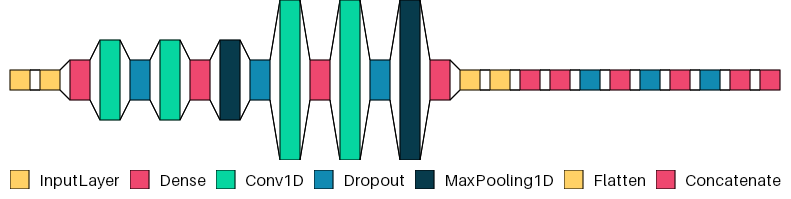

In [17]:
font = ImageFont.load_default(size = 16)

visualkeras.layered_view(model, to_file='../images/model_architecture.png', legend=True,
                         draw_funnel=True, draw_volume=False,
                         one_dim_orientation="x", scale_xy=5, font=font)

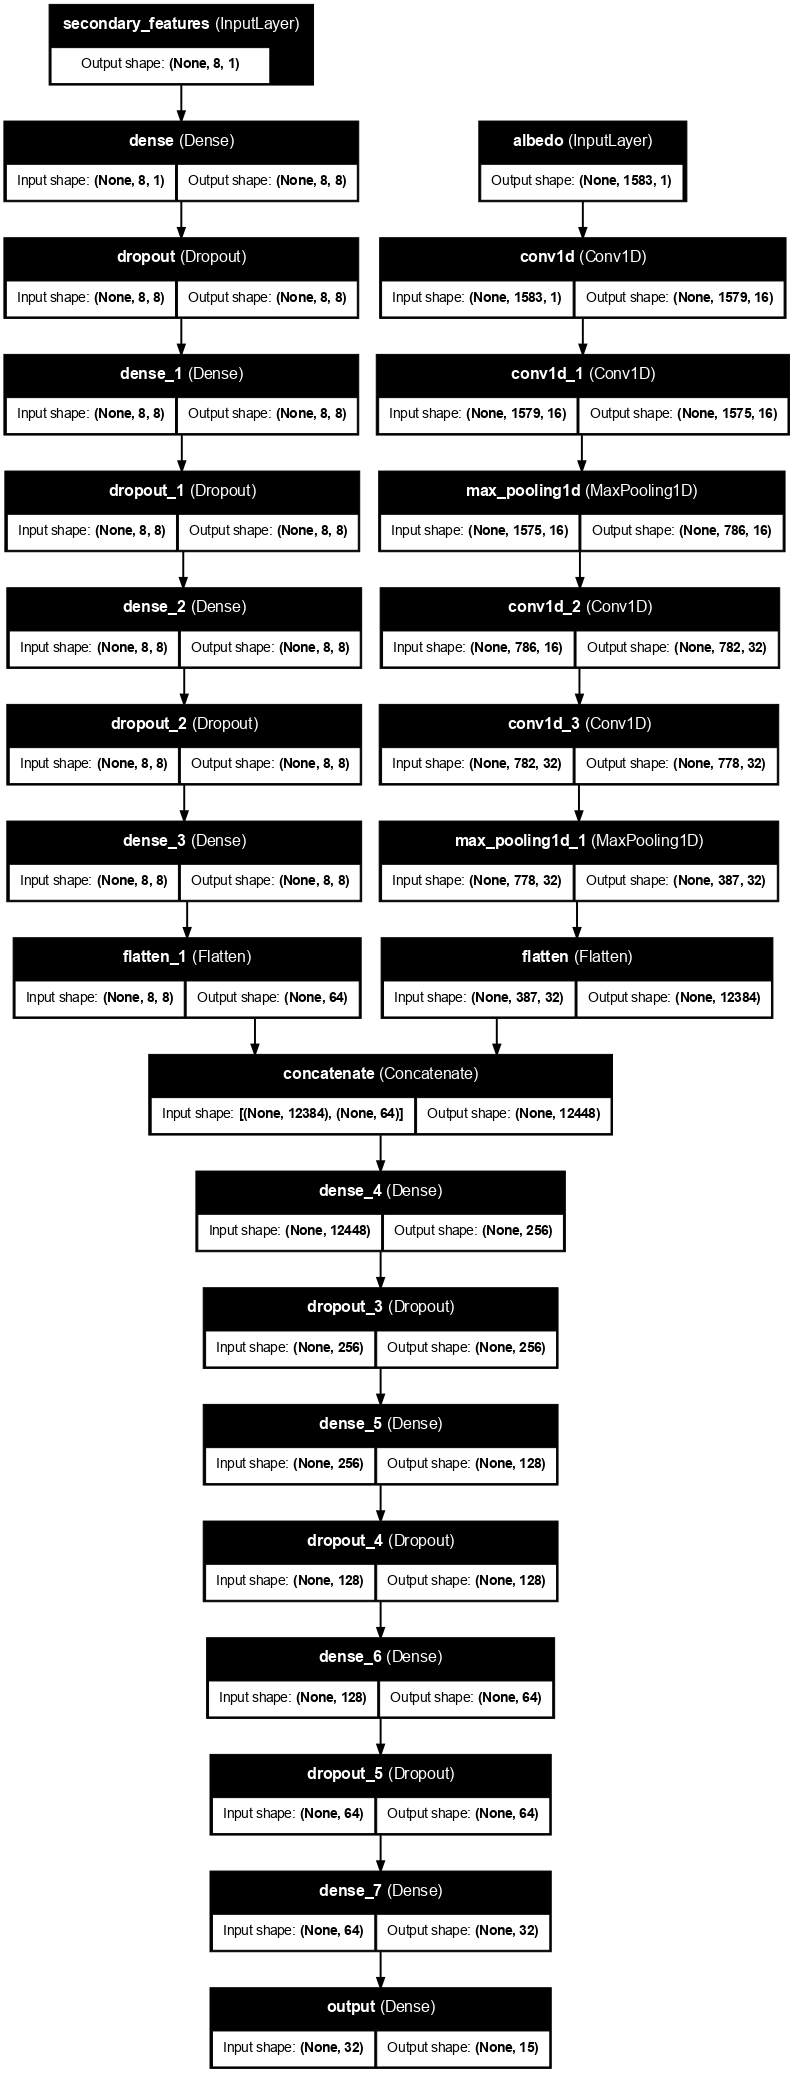

In [18]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=70)

In [19]:
epochs = 20
hist = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/20
     32/Unknown 12s 314ms/step - loss: 0.0368 - mean_squared_error: 0.0368

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 337ms/step - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 321ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0016 -

In [20]:
test_loss, test_metrics = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Metrics:", test_metrics)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Test Loss: 0.001088946359232068
Test Metrics: 0.001088946359232068


In [21]:
predictions = model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


In [22]:
batch[1][1]

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0.0000000e+00, 9.7929519e-01, 0.0000000e+00, 6.8873720e-04,
       1.2308955e-06, 9.7973933e-03, 8.9339042e-10, 8.0129361e-11,
       1.0211213e-02, 8.2532266e-11, 2.3355497e-06, 3.1806853e-06,
       6.9984003e-07, 0.0000000e+00, 0.0000000e+00], dtype=float32)>

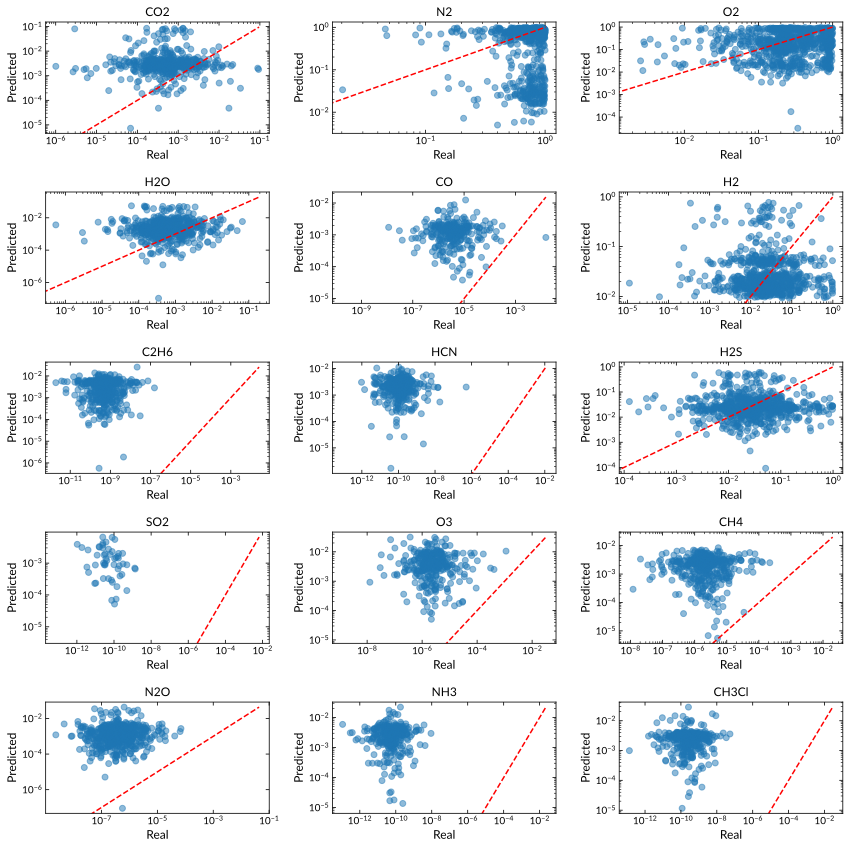

In [57]:
def scatter_plot_comparacoes(test_dataset, predictions):
    real_values = []
    for batch in test_dataset:
        real_values.extend(batch[1].numpy())
        
    real_values = np.array(real_values)
    
    moleculas = ['CO2', 'N2', 'O2', 'H2O', 'CO', 'H2', 'C2H6', 'HCN', 'H2S', 'SO2', 'O3', 'CH4', 'N2O', 'NH3', 'CH3Cl']
    
    num_moleculas = real_values.shape[1]
    
    _, axes = plt.subplots(5, 3, figsize=(12, 12))
    axes = axes.flatten()
    for i in range(num_moleculas):
        ax = axes[i]
        ax.scatter(real_values[:, i], predictions[:, i], alpha=0.5)

        min_val = min(real_values[:, i].min(), predictions[:, i].min())
        max_val = max(real_values[:, i].max(), predictions[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        ax.set_title(f'{moleculas[i]}')
        ax.set_xlabel('Real')
        ax.set_ylabel('Predicted')
        ax.set_xscale("log")
        ax.set_yscale("log")

    plt.tight_layout()
    plt.show()

scatter_plot_comparacoes(test_dataset, predictions)